## Import libraries

In [19]:
import os
import re
import json
from joblib import Parallel, delayed
from pathlib import Path
import joblib

import numpy as np
import pandas as pd
import time
from collections import defaultdict
from IPython.display import display, Markdown
import torch
import torch.nn.utils.prune as prune

# Modeling
from sklearn.metrics import mean_absolute_percentage_error as mape
from tabpfn import TabPFNRegressor
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Load Data

In [20]:
# Path to training and test data
DATA_FILE =  "dataset/train.csv" 
TEST_FILE =  "dataset/test.csv" 

# 1. Load dataset from the CSV file
df_train = pd.read_csv(DATA_FILE)
df_test = pd.read_csv(TEST_FILE)

# 2. Define Features (X) and Targets (y) (the component columns)
feature_cols = df_train.loc[:, "Component1_fraction":"Component5_Property10"].columns

# 3. Targets are the blend property columns
target_cols = df_train.loc[:, "BlendProperty1":"BlendProperty10"].columns
X_train = df_train[feature_cols]
y_train = df_train[target_cols]

X_test = df_test[feature_cols]
X_test.head(4)

,Component1_fraction,Component2_fraction,Component3_fraction,Component4_fraction,Component5_fraction,Component1_Property1,Component2_Property1,Component3_Property1,Component4_Property1,Component5_Property1,...,Component1_Property9,Component2_Property9,Component3_Property9,Component4_Property9,Component5_Property9,Component1_Property10,Component2_Property10,Component3_Property10,Component4_Property10,Component5_Property10
0,0.18,0.05,0.32,0.37,0.08,-0.177804,-0.741219,0.769821,-0.877069,0.602809,...,-0.265376,0.123432,0.028533,-0.173365,1.297923,0.323299,-0.315146,0.625518,-0.514342,-0.777057
1,0.00,0.50,0.00,0.37,0.13,2.501354,0.177344,-0.498739,-0.196742,-1.943463,...,-0.787677,-0.757905,-0.280561,-1.965970,0.543475,-0.906851,0.962341,-0.183757,0.310871,-1.329042
2,0.16,0.00,0.17,0.50,0.17,1.547324,0.891479,0.030627,-0.368678,-0.294728,...,-0.710026,-1.422693,0.874071,-1.016144,0.093525,1.048525,-1.321851,0.356640,-0.869543,-0.177255
3,0.50,0.00,0.17,0.16,0.17,-0.424427,1.016862,-1.182979,-0.854225,-0.830186,...,-0.551366,0.257105,-0.077337,-0.721031,-0.760365,-0.507690,1.346556,-0.001529,-1.008445,1.726105


## Features (from Auto FE ML Pipeline in final_submission dir)

In [21]:
PROPS = [2, 4, 8, 9]
TRAIN_OUT_DIR = Path("../final_submission/X_train")
FEATURES_DIR = Path("./features")
FEATURES_DIR.mkdir(exist_ok=True)

def save_feature_jsons_from_csv(train_out_dir=TRAIN_OUT_DIR, props=PROPS, out_dir=FEATURES_DIR):
    for p in props:
        tgt = f"BlendProperty{p}"
        csv_path = train_out_dir / f"X_train_{tgt}.csv"
        df = pd.read_csv(csv_path, nrows=1) # read only the first row into memory
        cols = [str(c) for c in df.columns]
        cols = list(dict.fromkeys(cols))
        payload = {"features": cols}

        fp = out_dir / f"features_autofeat_prop{p}.json"
        with open(fp, "w") as f:
            json.dump(payload, f, indent=2)
        print(f"📝 Saved {fp}  ({len(cols)} features)")

# save engineered autofeat features json
save_feature_jsons_from_csv()

📝 Saved features/features_autofeat_prop2.json  (110 features)
📝 Saved features/features_autofeat_prop4.json  (103 features)
📝 Saved features/features_autofeat_prop8.json  (144 features)
📝 Saved features/features_autofeat_prop9.json  (117 features)


> Extract all features generated by autofeat FE generation + selection for properties 2, 4, 8, 9
> >For properties 1, 3, 5, 6, 7, 10 we use the most relevant features from Model-Based Supervised Feature Importance Using LightGBM (gain importance)

In [22]:
# Read only headers from CSV
df_test_cols = pd.read_csv(TEST_FILE, nrows=0)

# Convert column names to a list
col_names = [c for c in df_test_cols.columns if c != "ID"]

# Save to JSON file
with open("features/column_names.json", "w") as f:
    json.dump(col_names, f, indent=4)

print("Column names saved to column_names.json")

Column names saved to column_names.json


### Helper fuction to compute features from feature names in ./fealist

In [23]:
def generate_features_from_list(df: pd.DataFrame, feature_list: list) -> pd.DataFrame:
    """
    Builds all requested features from a DataFrame using `eval`.
    """
    print(f"  -> Generating {len(feature_list)} features...")

    features = {} # hold the results
    for original_name in feature_list:
        # eval-friendly name for Abs -> abs
        eval_name = original_name.replace('Abs', 'abs')
        try:
            features[original_name] = df.eval(eval_name, engine='numexpr')
        except Exception as e:
            print(f"    -> ⚠️ Could not calculate '{original_name}'. Error: {e}. Filling NaN.")
            features[original_name] = pd.Series(np.nan, index=df.index)

    return pd.DataFrame(features)

### Use the extracted feature names to compute relevant features on data

In [24]:
if __name__ == '__main__':
    # --- Feature Calculation ---
    print("\n--- Calculating Features for All Targets ---")
    all_calculated_features = {}

    for target in target_cols:
        print(f"\nProcessing: {target}")
        prop_number = target.replace('BlendProperty', '')
        json_file_path = f"features/features_prop{prop_number}.json"

        if not os.path.exists(json_file_path):
            print(f"  -> ❌ ERROR: Skipping {target}, feature file '{json_file_path}' not found.")
            continue

        with open(json_file_path, 'r') as f:
            feature_definitions = json.load(f)

        required_features_list = feature_definitions.get('features', [])
        print(f"  -> ✅ Loaded {len(required_features_list)} feature definitions.")

        X_train_calculated = generate_features_from_list(X_train, required_features_list)
        all_calculated_features[target] = X_train_calculated
        print(f"  -> ✅ Stored calculated features for {target}.")



--- Calculating Features for All Targets ---

Processing: BlendProperty1
  -> ✅ Loaded 29 feature definitions.
  -> Generating 29 features...
  -> ✅ Stored calculated features for BlendProperty1.

Processing: BlendProperty2
  -> ✅ Loaded 110 feature definitions.
  -> Generating 110 features...
  -> ✅ Stored calculated features for BlendProperty2.

Processing: BlendProperty3
  -> ✅ Loaded 45 feature definitions.
  -> Generating 45 features...
  -> ✅ Stored calculated features for BlendProperty3.

Processing: BlendProperty4
  -> ✅ Loaded 103 feature definitions.
  -> Generating 103 features...
  -> ✅ Stored calculated features for BlendProperty4.

Processing: BlendProperty5
  -> ✅ Loaded 12 feature definitions.
  -> Generating 12 features...
  -> ✅ Stored calculated features for BlendProperty5.

Processing: BlendProperty6
  -> ✅ Loaded 26 feature definitions.
  -> Generating 26 features...
  -> ✅ Stored calculated features for BlendProperty6.

Processing: BlendProperty7
  -> ✅ Loaded 31

In [25]:
def view_features_panel(
    all_calculated_features: dict,
    target_to_view: str,
    sample_rows: int = 5,
    show_columns: int = 10,   # how many columns to render in head() before it truncates
):
    """Inspector for one target's feature DF."""
    df = all_calculated_features[target_to_view]

    # ---- Header ----
    display(Markdown(f"## Features for **`{target_to_view}`**"))
    
    # ---- Stats----
    n_rows, n_cols = df.shape
    total = n_rows * n_cols if n_rows and n_cols else 1
    miss_total = int(df.isna().sum().sum())
    miss_pct = 100.0 * miss_total / total
    mem_mb = df.memory_usage(deep=True).sum() / 1e6

    summary = pd.DataFrame({
        "rows":        [n_rows],
        "cols":        [n_cols],
        "missing_total": [miss_total],
        "missing_pct": [miss_pct],
        "mem_mb":     [mem_mb],
    })
    display(summary.style.format({"missing_pct":"{:.2f}%", "mem_mb":"{:.2f}"}).hide(axis="index"))

    # ---- Head ----
    display(Markdown(f"### Head (first **{sample_rows}** rows)"))
    with pd.option_context("display.max_columns", show_columns):
        display(df.head(sample_rows))

    # ---- Columns table ----
    display(Markdown("### Columns (feature names)"))
    cols_df = pd.DataFrame({
        "feature": df.columns,
        "dtype":   [df[c].dtype for c in df.columns],
        "non_null": df.notna().sum().values,
        "missing_pct": (df.isna().mean().values * 100),
    })
    display(
        cols_df
        .style
        .format({"missing_pct": "{:.2f}%"})
        .hide(axis="index")
    )

    # ---- Numeric summary ----
    num = df.select_dtypes(include=[np.number])
    if not num.empty:
        display(Markdown("### 📊 Numeric summary"))
        desc = num.describe().T
        display(
            desc.style
                .format("{:.4g}")
                .background_gradient(subset=["mean","std","50%"], axis=None)  # quick visual cues
        )
    else:
        display(Markdown("> _No numeric columns to summarize._"))


# Run for Blend Property 1
view_features_panel(all_calculated_features, "BlendProperty2")

## Features for **`BlendProperty2`**

rows,cols,missing_total,missing_pct,mem_mb
2000,110,0,0.00%,1.76


### Head (first **5** rows)

,Component1_fraction,Component2_fraction,Component3_fraction,Component4_fraction,Component5_fraction,...,Component5_Property2**3*exp(Component4_Property2),Component3_Property2**2*sqrt(Component3_fraction),Component3_fraction**3*Abs(Component5_Property10),sqrt(Component2_fraction)*sqrt(Component4_fraction),sqrt(Component2_fraction)*sqrt(Component3_fraction)
0,0.21,0.00,0.42,0.25,0.12,...,0.022869,0.011636,0.202181,0.000000,0.000000
1,0.02,0.33,0.19,0.46,0.00,...,0.360878,0.810345,0.006147,0.389615,0.250400
2,0.08,0.08,0.18,0.50,0.16,...,-0.172295,2.984824,0.002475,0.200000,0.120000
3,0.25,0.42,0.00,0.07,0.26,...,0.011660,0.000000,0.000000,0.171464,0.000000
4,0.26,0.16,0.08,0.50,0.00,...,0.275182,0.651360,0.001044,0.282843,0.113137


### Columns (feature names)

feature,dtype,non_null,missing_pct
Component1_fraction,float64,2000,0.00%
Component2_fraction,float64,2000,0.00%
Component3_fraction,float64,2000,0.00%
Component4_fraction,float64,2000,0.00%
Component5_fraction,float64,2000,0.00%
Component1_Property1,float64,2000,0.00%
Component2_Property1,float64,2000,0.00%
Component3_Property1,float64,2000,0.00%
Component4_Property1,float64,2000,0.00%
Component5_Property1,float64,2000,0.00%


### 📊 Numeric summary

,count,mean,std,min,25%,50%,75%,max
Component1_fraction,2000,0.1807,0.1632,0,0.03,0.14,0.29,0.5
Component2_fraction,2000,0.1829,0.1637,0,0.04,0.15,0.3,0.5
Component3_fraction,2000,0.1798,0.1663,0,0.02,0.14,0.29,0.5
Component4_fraction,2000,0.3421,0.1411,0.01,0.22,0.35,0.5,0.5
Component5_fraction,2000,0.1145,0.08022,0,0.05,0.12,0.18,0.29
Component1_Property1,2000,0.0002452,0.9994,-2.944,-0.6947,0.01198,0.6857,2.981
Component2_Property1,2000,-0.01732,1.006,-1.719,-0.7652,-0.03024,0.654,3.051
Component3_Property1,2000,0.001703,0.9989,-3.009,-0.7019,0.02133,0.6731,2.869
Component4_Property1,2000,-0.004653,1.007,-3.029,-0.6934,0.01677,0.6592,2.982
Component5_Property1,2000,-0.01826,1.009,-3.572,-0.7131,0.1949,1.032,1.032


In [28]:
%%time
# Groups for best hyperparams
group_A, group_B, group_C = {1, 3, 5, 6, 7, 10}, {2, 9}, {4, 8}

def params_for_prop(p):
    if p in group_A: return dict(n_estimators=16, softmax_temperature=1.0, average_before_softmax=True, random_state=0)
    if p in group_B: return dict(n_estimators=32, softmax_temperature=1.05, average_before_softmax=True, random_state=22)
    if p in group_C: return dict(n_estimators=32, softmax_temperature=1.0, average_before_softmax=True, random_state=20)
    raise ValueError(f"No params defined for property {p}")

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    if np.isnan(y_pred).any(): return np.nan
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))

# Output dir
models_dir = Path("./models_full"); models_dir.mkdir(parents=True, exist_ok=True)

# Device check
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except ImportError:
    device = "cpu"
print(f"🖥️ Using device: {device}")

summary_rows = []

for tgt in target_cols:
    prop_num = int(tgt.replace("BlendProperty", ""))
    if tgt not in all_calculated_features or tgt not in y_train.columns: 
        continue

    X_tr_df = all_calculated_features[tgt]
    X_tr, y_tr = X_tr_df.values.astype(np.float32), y_train[tgt].values.astype(np.float32)
    hp = params_for_prop(prop_num)

    try:
        model = TabPFNRegressor(device=device, ignore_pretraining_limits=True, **hp)
        print(f"⏳ Training {tgt} on {device}...")
        model.fit(X_tr, y_tr)
    except Exception as e:
        print(f"  ↩︎ GPU failed ({e}), retrying on CPU...")
        device = "cpu"
        model = TabPFNRegressor(device=device, ignore_pretraining_limits=True, **hp).fit(X_tr, y_tr)

    model_path = models_dir / f"model_{tgt}.pkl"
    joblib.dump(model, model_path, compress=3)
    
    train_mape = np.mean(np.abs(y_tr - model.predict(X_tr)) / np.maximum(np.abs(y_tr), 1e-8)) * 100
    
    summary_rows.append({
        "target": tgt, **hp, "device": getattr(model, "device", device),
        "n_feats": len(X_tr_df.columns), "train_mape_%": train_mape,
        "model_path": str(model_path)
    })

    if 'torch' in globals() and torch.cuda.is_available():
        device = "cuda"

# Save one CSV with all results
summary_df_best = pd.DataFrame(summary_rows).sort_values("target")
csv_path = models_dir / "training_summary.csv"
summary_df_best.to_csv(csv_path, index=False)

print(summary_df_best.to_string(index=False))
print(f"\n✅ Saved {len(summary_df_best)} models and summary CSV to: {models_dir.resolve()}")

🖥️ Using device: cuda
⏳ Training BlendProperty1 on cuda...
⏳ Training BlendProperty2 on cuda...
⏳ Training BlendProperty3 on cuda...
⏳ Training BlendProperty4 on cuda...
⏳ Training BlendProperty5 on cuda...
⏳ Training BlendProperty6 on cuda...
⏳ Training BlendProperty7 on cuda...
⏳ Training BlendProperty8 on cuda...
⏳ Training BlendProperty9 on cuda...
⏳ Training BlendProperty10 on cuda...
         target  n_estimators  softmax_temperature  average_before_softmax  random_state device  n_feats  train_mape_%                            model_path
 BlendProperty1            16                 1.00                    True             0   cuda       29      5.992000  models_full/model_BlendProperty1.pkl
BlendProperty10            16                 1.00                    True             0   cuda       61      6.044683 models_full/model_BlendProperty10.pkl
 BlendProperty2            32                 1.05                    True            22   cuda      110      4.740435  models_full/mode

In [10]:
%%time
# Output dir
models_dir = Path("./models_default"); models_dir.mkdir(parents=True, exist_ok=True)

# Device check
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except ImportError:
    device = "cpu"
print(f"🖥️ Using device: {device}")

summary_rows = []

for tgt in target_cols:
    prop_num = int(tgt.replace("BlendProperty", ""))
    if tgt not in all_calculated_features or tgt not in y_train.columns: 
        continue

    X_tr_df = X_train
    X_tr, y_tr = X_tr_df.values.astype(np.float32), y_train[tgt].values.astype(np.float32)

    try:
        model = TabPFNRegressor(device=device, ignore_pretraining_limits=True)
        print(f"⏳ Training {tgt} on {device}...")
        model.fit(X_tr, y_tr)
    except Exception as e:
        print(f"  ↩︎ GPU failed ({e}), retrying on CPU...")
        device = "cpu"
        model = TabPFNRegressor(device=device, ignore_pretraining_limits=True).fit(X_tr, y_tr)

    model_path = models_dir / f"model_{tgt}.pkl"
    joblib.dump(model, model_path, compress=3)

    try:
        train_mape = np.mean(np.abs(y_tr - model.predict(X_tr)) / np.maximum(np.abs(y_tr), 1e-8)) * 100
    except: 
        train_mape = np.nan

    summary_rows.append({
        "target": tgt,
        "device": getattr(model, "device", device),
        "n_feats": len(X_tr_df.columns),
        "train_mape_%": train_mape,
        "model_path": str(model_path)
    })

    if 'torch' in globals() and torch.cuda.is_available():
        device = "cuda"

# Save one CSV with all results
summary_df_default = pd.DataFrame(summary_rows).sort_values("target")
csv_path = models_dir / "training_summary.csv"
summary_df_default.to_csv(csv_path, index=False)

print(summary_df_default.to_string(index=False))
print(f"\n✅ Saved {len(summary_df_default)} models and summary CSV to: {models_dir.resolve()}")

🖥️ Using device: cuda
⏳ Training BlendProperty1 on cuda...
⏳ Training BlendProperty2 on cuda...
⏳ Training BlendProperty3 on cuda...
⏳ Training BlendProperty4 on cuda...
⏳ Training BlendProperty5 on cuda...
⏳ Training BlendProperty6 on cuda...
⏳ Training BlendProperty7 on cuda...
⏳ Training BlendProperty8 on cuda...
⏳ Training BlendProperty9 on cuda...
⏳ Training BlendProperty10 on cuda...
         target device  n_feats  train_mape_%                               model_path
 BlendProperty1   cuda       55     49.465950  models_default/model_BlendProperty1.pkl
BlendProperty10   cuda       55     11.963454 models_default/model_BlendProperty10.pkl
 BlendProperty2   cuda       55     15.868828  models_default/model_BlendProperty2.pkl
 BlendProperty3   cuda       55     18.679895  models_default/model_BlendProperty3.pkl
 BlendProperty4   cuda       55     13.846676  models_default/model_BlendProperty4.pkl
 BlendProperty5   cuda       55      1.036722  models_default/model_BlendProperty5.pk

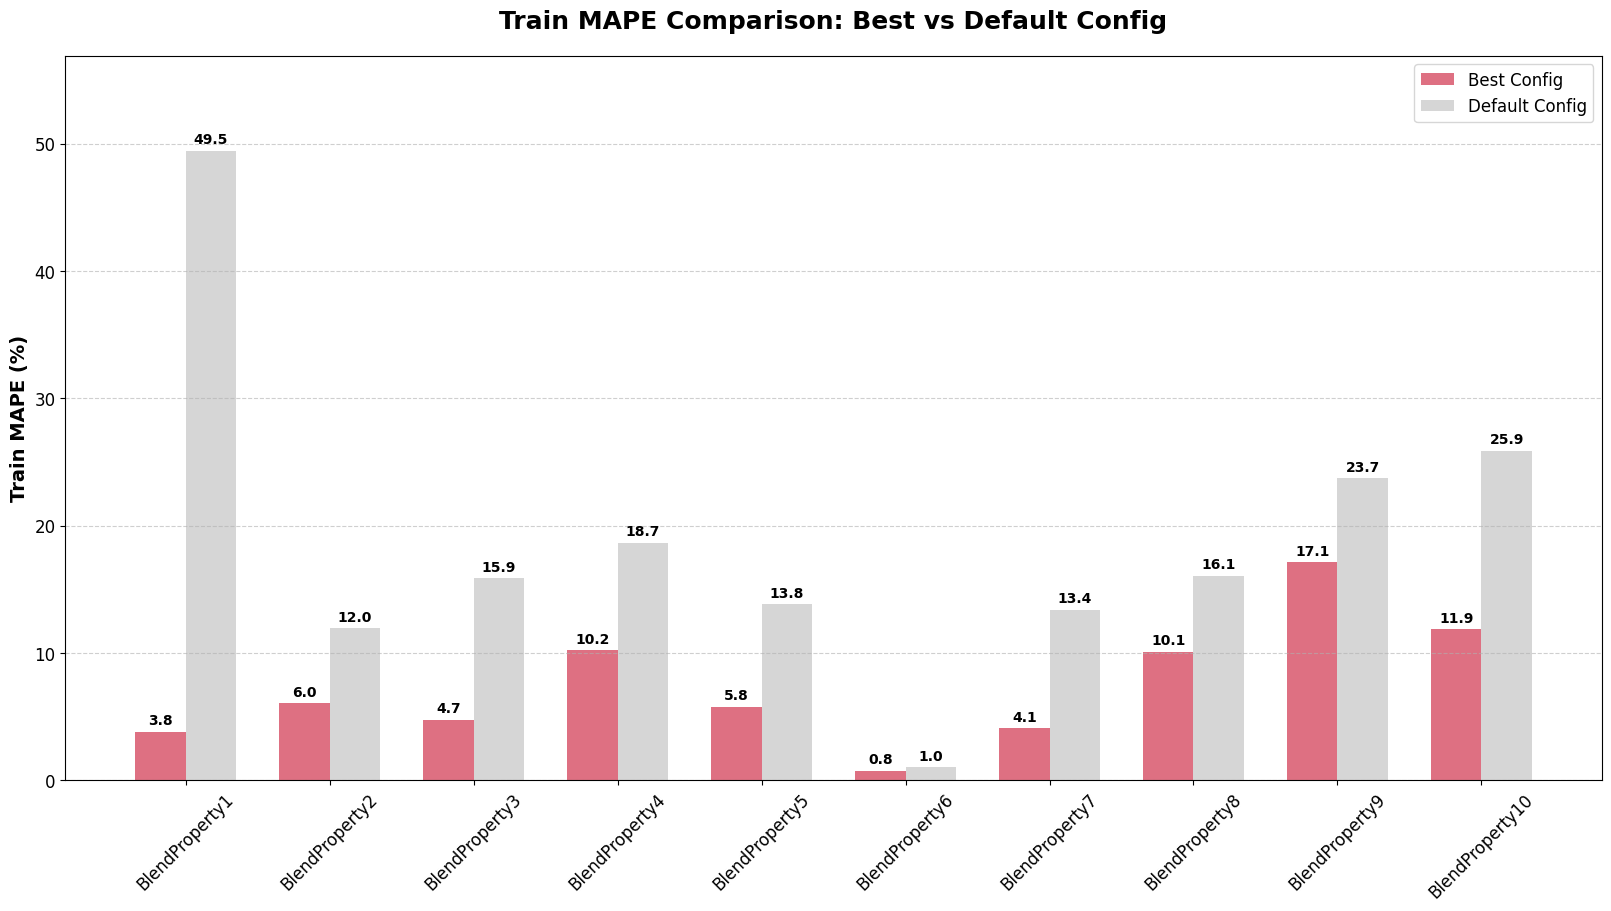

In [14]:
x = np.arange(len(summary_df_best["target"]))
width = 0.35  

fig, ax = plt.subplots(figsize=(16, 9), layout='constrained')
nn_colors = LinearSegmentedColormap.from_list("nn_red", ["#999999", "#ffffff", "#C8102E"])

rects1 = ax.bar(x - width/2, summary_df_best["train_mape_%"], width,
                label="Best Config", color=nn_colors(0.8))
rects2 = ax.bar(x + width/2, summary_df_default["train_mape_%"], width,
                label="Default Config", color=nn_colors(0.3))

ax.bar_label(rects1, padding=3, fontsize=10, weight='bold', fmt="%.1f")
ax.bar_label(rects2, padding=3, fontsize=10, weight='bold', fmt="%.1f")

ax.set_ylabel('Train MAPE (%)', fontsize=14, fontweight='bold')
ax.set_title('Train MAPE Comparison: Best vs Default Config', fontsize=18, fontweight='bold', pad=20)
targets_sorted = sorted(summary_df_best["target"], key=lambda x: int("".join(filter(str.isdigit, x))))
ax.set_xticks(x, targets_sorted)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(0, max(summary_df_best["train_mape_%"].max(),
                   summary_df_default["train_mape_%"].max()) * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.savefig("../final_submission/plots/mape_comparison.png", dpi=300)
plt.show()

In [5]:
def compute_error_metrics(path1, path2):
    """Compute MAPE, Max AE, Mean AE, and the value causing Max AE per column."""
    
    # Load files
    df1 = pd.read_csv(path1) if Path(path1).suffix.lower() == ".csv" else pd.read_excel(path1)
    df2 = pd.read_csv(path2) if Path(path2).suffix.lower() == ".csv" else pd.read_excel(path2)
    
    # Only compare common columns
    common_cols = df1.columns.intersection(df2.columns)
    if len(common_cols) == 0:
        raise ValueError("No common columns found between the two sheets.")
    
    metrics = {}
    for col in common_cols:
        y_true = np.asarray(df1[col])
        y_pred = np.asarray(df2[col])
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        
        if not mask.any():
            metrics[col] = {"MAPE_%": np.nan, "Max_AE": np.nan, "Mean_AE": np.nan, "Value_Max_AE": np.nan}
            continue
        
        y_true, y_pred = y_true[mask], y_pred[mask]
        ae = np.abs(y_true - y_pred)
        mape_val = np.mean(ae / np.maximum(np.abs(y_true), 1e-8)) * 100
        max_ae_idx = np.argmax(ae)
        
        metrics[col] = {
            "MAPE_%": mape_val,
            "Max_AE": ae[max_ae_idx],
            "Mean_AE": np.mean(ae),
            "Value_Max_AE": y_true[max_ae_idx] 
        }
    
    return pd.DataFrame.from_dict(metrics, orient='index').sort_index()

# --- USAGE ---
path_sheet1 = "../final_submission/submission.csv"   
path_sheet2 = "predictions_b6c6fa8f.csv"

error_metrics_df = compute_error_metrics(path_sheet1, path_sheet2)
print(error_metrics_df)

                    MAPE_%    Max_AE   Mean_AE  Value_Max_AE
BlendProperty1    2.779547  0.029467  0.005143      1.996765
BlendProperty10   8.936998  0.040546  0.008175     -0.627081
BlendProperty2    3.683588  0.029662  0.006782     -1.236199
BlendProperty3    2.708225  0.088075  0.005071      0.427931
BlendProperty4   12.940620  0.059673  0.008227      0.407991
BlendProperty5    0.338067  0.239232  0.003010      1.810743
BlendProperty6    2.125169  0.037890  0.006319     -2.270928
BlendProperty7    5.965278  0.072199  0.011558      0.374967
BlendProperty8   20.744559  0.193354  0.038837     -1.108972
BlendProperty9   12.449557  0.111859  0.015911     -1.338658
ID                0.000000  0.000000  0.000000      1.000000
